Sphericity factor: 7.67
Hemispherical diffusion is most likely to be accurate
Steady state current for hemispherical diffusion: 23.85 nA
Steady state current for planar diffusion: 1.09 nA


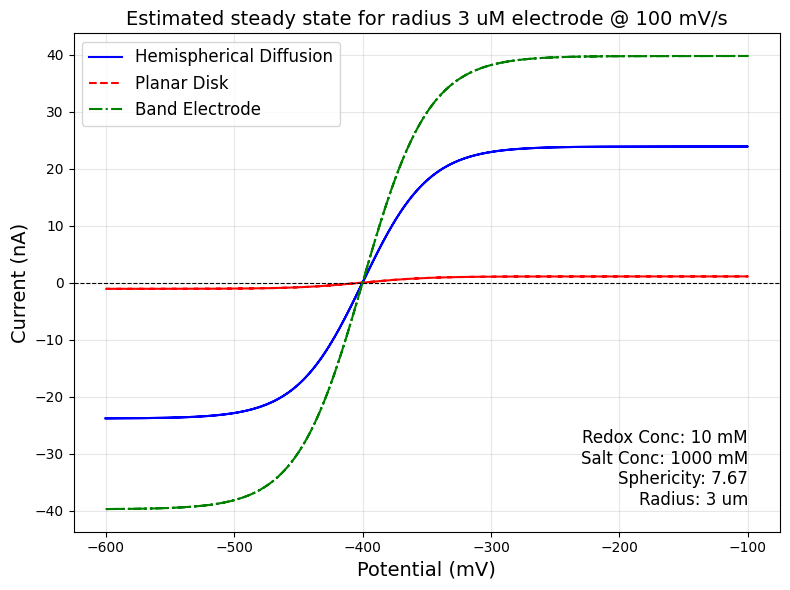

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
radius_um = 3                  # Radius (um)
D = 2.06e-9                    # Diffusion coefficient of the redox species (m^2/s)
redox_concentration_mM = 10    # Concentration of redox species (mM)
oxidant_concentration_mM = 10  # Concentration of oxidant species (mM)
salt_concentration_mM = 1000   # Concentration of supporting electrolyte (mM)

n = 1  # Number of electrons transferred
alkane_coverage = 0            # Fractional coverage by alkane layer
E_start = -0.6                 # Starting potential (V)
E_end = -0.1                   # Ending potential (V)
E_step = 1e-3                  # Potential step (V)
E0 = -0.4                      # Standard potential (V)
v = 0.1                        # Scan rate (V/s)

# Band electrode dimensions
band_length_um = 10  # Length of the band electrode (um)
band_width_um = 2    # Width of the band electrode (um)

#####################################################################################################
# Nernst equation parameters
F = 96485  # Faraday's constant (C/mol)
R = 8.314  # Gas constant (J/(mol*K))
T = 298.15  # Temperature (K)
Cdl = 20e-6  # Specific double-layer capacitance (F/cm²)
Ru = 1e3     # Uncompensated resistance (Ω)
k0 = 1e-2    # Standard rate constant (cm/s)

# Unit conversions
radius = radius_um * 1e-6  # Convert radius to meters
band_length = band_length_um * 1e-6  # Convert length to meters
band_width = band_width_um * 1e-6  # Convert width to meters
redox_concentration = redox_concentration_mM              # Convert mM to (mol/m³ in SI units)
oxidant_concentration = oxidant_concentration_mM          # Convert mM to (mol/m³ in SI units)

# Planar disk electrode area
Area_Planar = np.pi * radius**2 * (1 - alkane_coverage)

# Band electrode constants
band_area = band_length * band_width
constant_band = 2 * n * F * band_area * D / band_width  # Current for band electrode

# Constants for planar and hemispherical diffusion
constant_planar = 0.4463 * n * F * Area_Planar * np.sqrt(D * n * F / (R * T) * v)
constant_hemisphere = 4 * radius * n * D * F

# Determine which geometry is likely to be more accurate
sphericity_factor = np.sqrt(D / radius**2 / (n * F * v / (R * T)))

print(f"Sphericity factor: {sphericity_factor:.2f}")
if sphericity_factor > 1:
    print("Hemispherical diffusion is most likely to be accurate")
    
    
print(f'Steady state current for hemispherical diffusion: {constant_hemisphere*oxidant_concentration*1e9:.2f} nA') 
print(f'Steady state current for planar diffusion: {constant_planar*oxidant_concentration*1e9:.2f} nA') 

# Generate potential range
E_forward = np.arange(E_start, E_end + E_step, E_step)
E_reverse = np.arange(E_end, E_start - E_step, -E_step)
E = np.concatenate((E_forward, E_reverse))

# Pre-allocate arrays for the current
current_ss = np.zeros_like(E)  # Steady-state current for the hemispherical UME
current_P = np.zeros_like(E)   # Planar disk-like current
current_band = np.zeros_like(E)  # Band electrode current

# Calculate current for each geometry
for i, potential in enumerate(E):
    # Nernstian equilibrium concentrations
    #reductant_fraction = 1 / (1 + np.exp((F / (R * T)) * (potential - E0)))
    #oxidant_fraction = 1 - reductant_fraction
    i_c = Cdl * Area_Planar * v * 1e4  # Convert to A/cm²

    # Kinetic parameter
    psi = k0 * np.sqrt(np.pi * D * F / (R * T * v))

    # Nernstian equilibrium concentrations
    eta = (F / (R * T)) * (potential - E0)
    reductant_fraction = 1 / (1 + np.exp(eta))
    oxidant_fraction = 1 - reductant_fraction
    
    # Steady-state current for hemispherical electrode
    i_ss = constant_hemisphere * (oxidant_concentration * reductant_fraction - redox_concentration * oxidant_fraction)
    
    # Planar diffusion current
    i_p = constant_planar * (oxidant_concentration * reductant_fraction - redox_concentration * oxidant_fraction)

    # Account for kinetics and uncompensated resistance
    current_ss[i] = (i_ss + i_c) / (1 + (i_ss + i_c) * Ru / (R * T / (n * F)))
    current_P[i] = (i_p + i_c) / (1 + (i_p + i_c) * Ru / (R * T / (n * F)))
    
    # Steady-state current for hemispherical electrode
    #current_ss[i] = constant_hemisphere * (oxidant_concentration * reductant_fraction - redox_concentration * oxidant_fraction)

    # Planar diffusion current
    #current_P[i] = constant_planar * (oxidant_concentration * reductant_fraction - redox_concentration * oxidant_fraction)

    # Band electrode current
    current_band[i] = constant_band * (oxidant_concentration * reductant_fraction - redox_concentration * oxidant_fraction)

# Plotting the cyclic voltammogram
plt.figure(figsize=(8, 6))

# Plot steady-state current for the hemispherical geometry
plt.plot(1000*E, current_ss * -1e9, label="Hemispherical Diffusion", color='b')

# Plot planar disk-like geometry current
plt.plot(1000*E, current_P * -1e9, label="Planar Disk", color='r', linestyle='--')

# Plot band electrode current
plt.plot(1000*E, current_band * -1e9, label="Band Electrode", color='g', linestyle='-.')

# Axis labels and title (US convention: E vs I)
plt.xlabel("Potential (mV)", fontsize=14)
plt.ylabel("Current (nA)", fontsize=14)
plt.title(f"Estimated steady state for radius {radius_um} uM electrode @ {v*1000:.0f} mV/s", fontsize=14)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
#add text to show concentration, spherecity factor, and electrode size
graphMin = np.min([0,np.min(current_ss),np.min(current_P),np.min(current_band)])*1e9 
plt.text(1000*E_end,graphMin,
         f"Redox Conc: {redox_concentration_mM} mM\nSalt Conc: {salt_concentration_mM} mM\nSphericity: {sphericity_factor:.2f}\nRadius: {radius_um} um",
         fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()